# Упражнения 
Для этих упражнений мы используем данные из FRED, касающиеся производства электроэнергии и газа с января 1992 года по январь 2019 года (325 записей).

Источник https://fred.stlouisfed.org/series/IPG2211A2N

План:
* Выполнение стандартного импорта, загрузка и построение набора данных (код предоставлен)
* Подготовить данные для модели LSTM
* Определить модель LSTM, функцию потерь и оптимизатор
* Обучение модели
* Оценка модели по тестовым данным 
* ДОПОЛНИТЕЛЬНО: построение графика результатов


## Импорт, загрузка данных и вывод графиков
Запустите ячейки ниже, чтобы загрузить библиотеки, необходимые для этого упражнения и набор данных по производству энергии, и построить данные.

In [2]:
# запустите ячейку:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# запустите ячейку:
df = pd.read_csv('EnergyProduction.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,84.2749
1992-02-01,79.2137
1992-03-01,73.6199
1992-04-01,68.7910
1992-05-01,66.3691


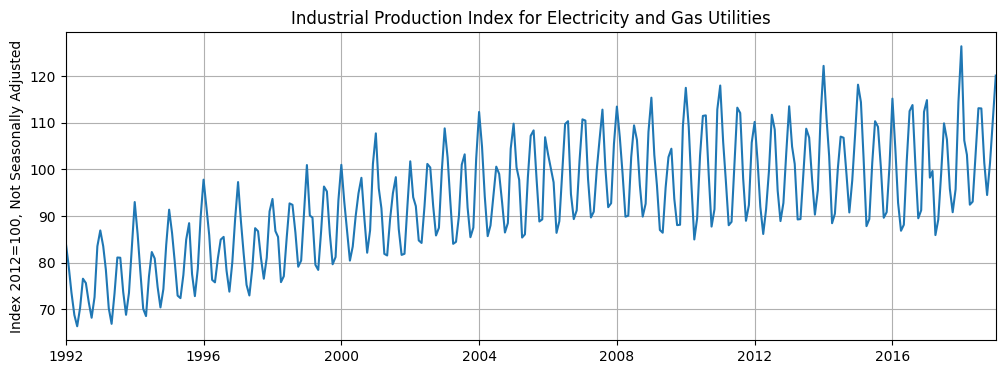

In [4]:
# запустите ячейку:
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

# Подготовьте данные
План:
* разделить данные на обучающие и тестовые наборы
* нормализовать обучающий набор
* подготовить (с помощью окна) пары seq / label для LSTM

## 1. Разделите данные на обучающие и тестовые наборы
Работая с window_size, равным 12, разделите набор данных на последовательность из 313 записей обучения (включая окно) и тестовый набор из 12 записей.

In [5]:
# Ваш код
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

In [6]:
# запустите ячейку чтобы проверить результаты:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


In [3]:
# не пишите код здесь

Train: 313
Test:  12


## 2. Нормализовать тренировочный набор
Масштабируйте тренировочный набор, чтобы он соответствовал диапазону [-1,1].

In [7]:
# Ваш код
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
print(f"Min: {train_norm.min()}")
print(f"Max: {train_norm.max()}")
print(f"Mean: {train_norm.mean()}")
print(f"Type: {type(train_norm)}")

Min: -1.0
Max: 1.0
Mean: -0.11313327314399416
Type: <class 'numpy.ndarray'>


In [8]:
# запустите ячейку чтобы проверить результаты:
print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

First item, original: 84.2749
First item, scaled:  [-0.40307533]


In [4]:
# не пишите код здесь

First item, original: 85.556
First item, scaled: [-0.4091274]


## 3. Подготовить данные для LSTM
Подготовьте с помощью окна список пар последовательность / метка для подачи на вход модели LSTM.

In [9]:
# Запустите эту ячейку
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [12]:
# Ваш код
train_data = input_data(train_norm, window_size)

In [13]:
# запустите ячейку чтобы проверить результаты:
print(f'Train_data: {len(train_data)}')  # должно быть 301

Train_data: 301


In [6]:
# не пишите код здесь

Train_data: 301


## 4. Определите модель
Создайте модель, которая имеет слой (1,64) LSTM и (64,1) полносвязнный линейный слой. Обязательно инициализируйте $h_0$ и $c_0$ и возвращайте только последнее предсказанное значение.

In [14]:
# Ваш код
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Добавляем LSTM слой:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Добавляем полносвязный слой:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Инициализируем h0 и c0:
        self.hidden = (torch.zeros(1, 1, self.hidden_size),
                        torch.zeros(1, 1, self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1,- 1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # нам нужно только последнее значение

In [15]:
# запустите ячейку чтобы проверить результаты:
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [7]:
# не пишите код здесь

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

## 5. Определить функцию потерь и оптимизатор
Определите функцию потерь (criterion) и оптимизатор (optimizer). <br>
Вы можете использовать любые функции, какие захотите, хотя мы использовали MSELoss и Adam (скорость обучения 0,001) соответственно.

In [22]:
# Ваш код
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()    
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [8]:
# не пишите код здесь

## 6. Обучите модель
Только обучение, не нужнл отслеживать значения функции потерь, отображать результаты или проводить валидацию на тестовом наборе. 50 эпох. <br>
ДОПОЛНИТЕЛЬНО: Выводите на печать что-нибудь после каждой эпохи, чтобы показать прогресс в обучении.

In [23]:
# Ваш код
epochs = 50

import time
start_time = time.time()

for epoch in range(epochs):
    
    # извлекаем последовательность и метки из обучающего множества
    for seq, y_train in train_data:
        
        # сбрасываем параметры и скрытые состояния 
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))

        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # выводим результат обучения
    print(f'{epoch+1:2} of {epochs} epochs completedd')

 1 of 50 epochs completedd
 2 of 50 epochs completedd
 3 of 50 epochs completedd
 4 of 50 epochs completedd
 5 of 50 epochs completedd
 6 of 50 epochs completedd
 7 of 50 epochs completedd
 8 of 50 epochs completedd
 9 of 50 epochs completedd
10 of 50 epochs completedd
11 of 50 epochs completedd
12 of 50 epochs completedd
13 of 50 epochs completedd
14 of 50 epochs completedd
15 of 50 epochs completedd
16 of 50 epochs completedd
17 of 50 epochs completedd
18 of 50 epochs completedd
19 of 50 epochs completedd
20 of 50 epochs completedd
21 of 50 epochs completedd
22 of 50 epochs completedd
23 of 50 epochs completedd
24 of 50 epochs completedd
25 of 50 epochs completedd
26 of 50 epochs completedd
27 of 50 epochs completedd
28 of 50 epochs completedd
29 of 50 epochs completedd
30 of 50 epochs completedd
31 of 50 epochs completedd
32 of 50 epochs completedd
33 of 50 epochs completedd
34 of 50 epochs completedd
35 of 50 epochs completedd
36 of 50 epochs completedd
37 of 50 epochs completedd
3

In [9]:
# не пишите код здесь

1 of 50 epochs completed
2 of 50 epochs completed
3 of 50 epochs completed
4 of 50 epochs completed
5 of 50 epochs completed
6 of 50 epochs completed
7 of 50 epochs completed
8 of 50 epochs completed
9 of 50 epochs completed
10 of 50 epochs completed
11 of 50 epochs completed
12 of 50 epochs completed
13 of 50 epochs completed
14 of 50 epochs completed
15 of 50 epochs completed
16 of 50 epochs completed
17 of 50 epochs completed
18 of 50 epochs completed
19 of 50 epochs completed
20 of 50 epochs completed
21 of 50 epochs completed
22 of 50 epochs completed
23 of 50 epochs completed
24 of 50 epochs completed
25 of 50 epochs completed
26 of 50 epochs completed
27 of 50 epochs completed
28 of 50 epochs completed
29 of 50 epochs completed
30 of 50 epochs completed
31 of 50 epochs completed
32 of 50 epochs completed
33 of 50 epochs completed
34 of 50 epochs completed
35 of 50 epochs completed
36 of 50 epochs completed
37 of 50 epochs completed
38 of 50 epochs completed
39 of 50 epochs compl

### 9. Оцените модель, используя тестовое множество
Обязательно повторно инициализируйте скрытые параметры $h_0$ и $c_0$ перед запуском модели.

In [24]:
# Ваш код
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [25]:
# запустите ячейку чтобы проверить результаты:
preds[window_size:]

[0.28305888175964355,
 0.01765209436416626,
 -0.327312171459198,
 -0.20720142126083374,
 0.260385662317276,
 0.5188669562339783,
 0.27450424432754517,
 -0.06236664205789566,
 -0.2558880150318146,
 0.006572365760803223,
 0.5379199385643005,
 0.6325145363807678]

In [10]:
# не пишите код здесь

[0.25382155179977417,
 -0.0027704648673534393,
 -0.343053936958313,
 -0.21152164041996002,
 0.23945370316505432,
 0.4895053505897522,
 0.24688751995563507,
 -0.08669154345989227,
 -0.25793153047561646,
 0.022461334243416786,
 0.5438402891159058,
 0.6108715534210205]

## 10. Обратное преобразование предсказанных значений
Масштабируйте прогнозируемые значения до исходного диапазона, который был на тестовом наборе.

In [26]:
# Ваш код
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

In [27]:
# запустите ячейку чтобы проверить результаты:
true_predictions

array([[104.85669651],
       [ 96.89535546],
       [ 86.54754862],
       [ 90.15048077],
       [104.17657362],
       [111.93017237],
       [104.60008519],
       [ 94.49505343],
       [ 88.69004119],
       [ 96.56299961],
       [112.50169992],
       [115.33923042]])

In [11]:
# не пишите код здесь

array([[105.95129313],
       [ 98.05736803],
       [ 87.58871716],
       [ 91.63524249],
       [105.50927345],
       [113.20198736],
       [105.73797111],
       [ 95.47557801],
       [ 90.20746543],
       [ 98.83361172],
       [114.87357457],
       [116.93575791]])

## Дополнительно: Построить график
Постройте значения true_predictions вместе с исходными данными. Не забудьте создать диапазон значений даты и времени для прогнозируемых данных.

In [28]:
df

,IPG2211A2N
DATE,
1992-01-01,84.2749
1992-02-01,79.2137
1992-03-01,73.6199
1992-04-01,68.7910
1992-05-01,66.3691
...,...
2018-09-01,101.4058
2018-10-01,94.4922
2018-11-01,101.3895


In [33]:
# Ваш код
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

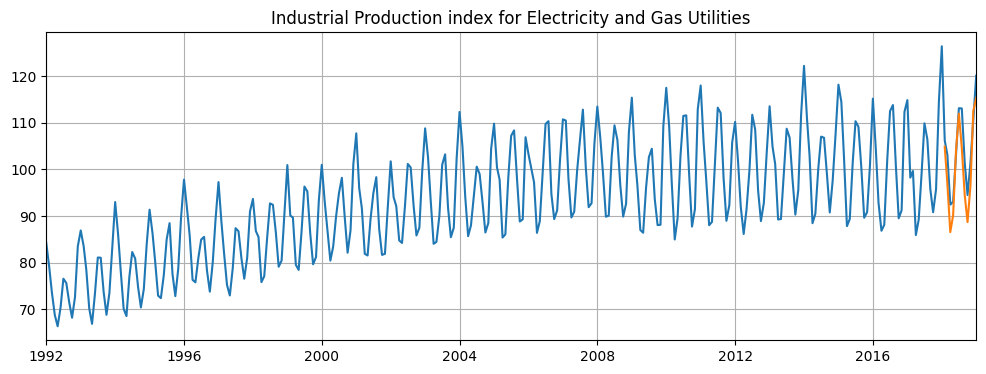

In [36]:
# напишите код для отображения графика
plt.figure(figsize=(12,4))
plt.title('Industrial Production index for Electricity and Gas Utilities')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

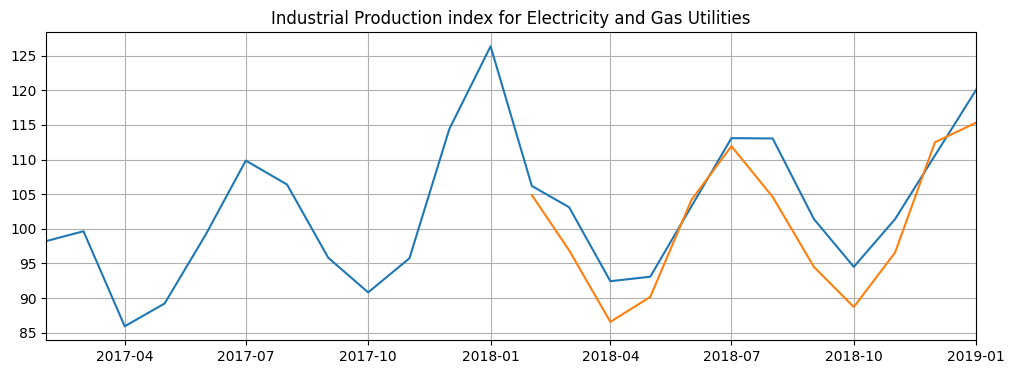

In [37]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production index for Electricity and Gas Utilities')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N']['2017-02-01':])
plt.plot(x,true_predictions)
plt.show()

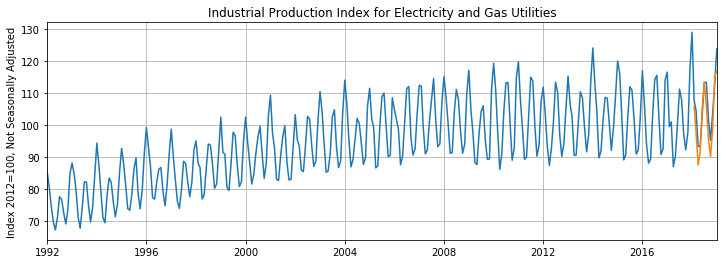

In [12]:
# не пишите код здесь

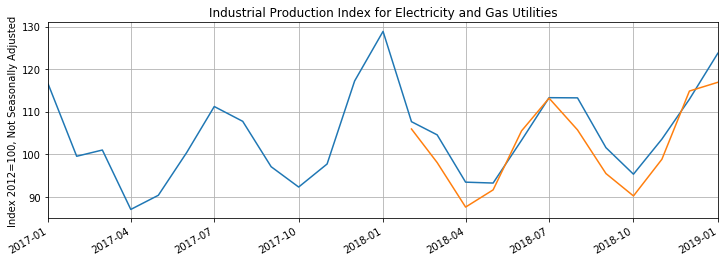

In [13]:
# не пишите код здесь

## Готово